In [81]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import mplfinance as mpf
import pandas as pd
import numpy as np
import bisect
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime,timedelta
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
client = CryptoHistoricalDataClient()

In [3]:
def get_data(start, end = None, ticker = "BTC", plot = True):
    global client
    def preprocess(data):
        data = data.reset_index(level = "timestamp").reset_index(level= "symbol")

        data = data[["open", "high", "low", "close", "volume", "timestamp"]]

        data.index = data["timestamp"]
        data.index = pd.to_datetime(data.index)
        data.drop(columns = ["timestamp"], axis = 1, inplace = True)

        return data

    if end is None:
        end = datetime.now()

    timeframe = TimeFrame.Minute

    request_params = CryptoBarsRequest(
        symbol_or_symbols=[f"{ticker}/USD"],
        timeframe=timeframe,
        start=start,
        end=end
    )

    btc_bars = client.get_crypto_bars(request_params)
    data = btc_bars.df

    data = preprocess(data)

    if plot:
        mpf.plot(data, type='candle', mav=(10, 20), volume=True, title=f"{ticker} Candlestick Chart", style='charles')
    return data

In [15]:
def resample(df, sample = 'H'):
    df = df.resample(sample).agg({
        'open': 'first',   # First open price in the hour
        'high': 'max',     # Maximum high price in the hour
        'low': 'min',      # Minimum low price in the hour
        'close': 'last',   # Last close price in the hour
        'volume': 'sum'    # Total volume in the hour
    }).dropna() 
    idx = list(df.index)
    return df, idx

In [5]:
def candleplot(df):
    mpf.plot(df, type='candle', mav=(10, 20), volume=True, title=f"Candlestick Chart", style='charles')
    return

In [31]:
def plot_interactive_strategy(data, column_prefix = "close", signal_column = "signal", indicator_columns = None, strategy_name = "", filename = "fig.html"):
    fig = go.Figure()

    # Plot Adjusted Close
    fig.add_trace(go.Scatter(
        x=data.index, y=data[f'{column_prefix}'],
        mode='lines', name='Adj Close', line=dict(color='blue')
    ))

    # Plot indicators
    # for indicator in indicator_columns:
    #     fig.add_trace(go.Scatter(
    #         x=data.index, y=data[indicator],
    #         mode='lines', name=indicator, line=dict(dash='dash')
    #     ))

    # Get buy/sell signals
    buy_signals = data[data[signal_column] == "bullish"].index
    sell_signals = data[data[signal_column] == "bearish"].index

    # Plot buy signals
    fig.add_trace(go.Scatter(
        x=buy_signals, y=data.loc[buy_signals, f'{column_prefix}'],
        mode='markers', name='Buy Signal',
        marker=dict(symbol='triangle-up', size=10, color='green')
    ))

    # Plot sell signals
    fig.add_trace(go.Scatter(
        x=sell_signals, y=data.loc[sell_signals, f'{column_prefix}'],
        mode='markers', name='Sell Signal',
        marker=dict(symbol='triangle-down', size=10, color='red')
    ))

    # Customize layout
    fig.update_layout(
        title=strategy_name,
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_dark',
        hovermode='x unified'
    )
    # Save to HTML
    fig.write_html(filename)
    print(f"Interactive graph saved as {filename}")

In [9]:
def fractal_fill(df, window_length = 5):
    def bearish_fractal(df, i, window_length):
        flag = 1
        left = i - int(window_length / 2)
        right = i + int(window_length / 2)

        for j in range(left, i):
            flag *= int(df.iloc[j]["high"] < df.iloc[j + 1]["high"])
            
        for j in  range(i, right):
            flag *= int(df.iloc[j]["high"] > df.iloc[j + 1]["high"])
        return bool(flag)

    def bullish_fractal(df, i, window_length):
        flag = 1
        left = i - int(window_length / 2)
        right = i + int(window_length / 2)

        for j in range(left, i):
            flag *= int(df.iloc[j]["low"] > df.iloc[j + 1]["low"])

        for j in range(i, right):
            flag *= int(df.iloc[j]["low"] < df.iloc[j + 1]["low"])
        return bool(flag)
    
    N = len(df)
    df["fractal_type"] = None
    i = 0
    for _, row in tqdm(df.iterrows(), total = N):
        if (i - window_length / 2) < 0 or (i +  window_length) >= N:
            i += 1
            continue
        
        if bearish_fractal(df, i, window_length):
            df.loc[df.index[i], "fractal_type"] = "bearish"
        if bullish_fractal(df, i, window_length):
            df.loc[df.index[i], "fractal_type"] = "bullish"
        i += 1

    return df

In [10]:
def find_closest(x, timestamps):
    index = bisect.bisect_left(timestamps, x)
    return index, timestamps[index - 1]

In [17]:
def tendency(index, signal = "bearish", use = '4h'):
    global data, timestamps

    if use in data.keys():
        d = data[use]
        t = timestamps[use]
    else:
        data[use], timestamps[use] = resample(data["minute"])

    if index < 4:
        return False
        
    first = t[index - 4]
    second = t[index - 3]
    third = t[index - 2]
    fourth = t[index - 1]

    if signal == "bearish":
        if ((d.loc[first, "high"] < d.loc[second, "high"]) and (d.loc[second, "high"] < d.loc[third, "high"]) and (d.loc[third, "high"] > d.loc[fourth, "high"])):
            return True
    if signal == "bullish":
        if ((d.loc[first, "low"] > d.loc[second, "low"]) and (d.loc[second, "low"] > d.loc[third, "low"]) and (d.loc[third, "low"] < d.loc[fourth, "low"])):
            return True
    return False

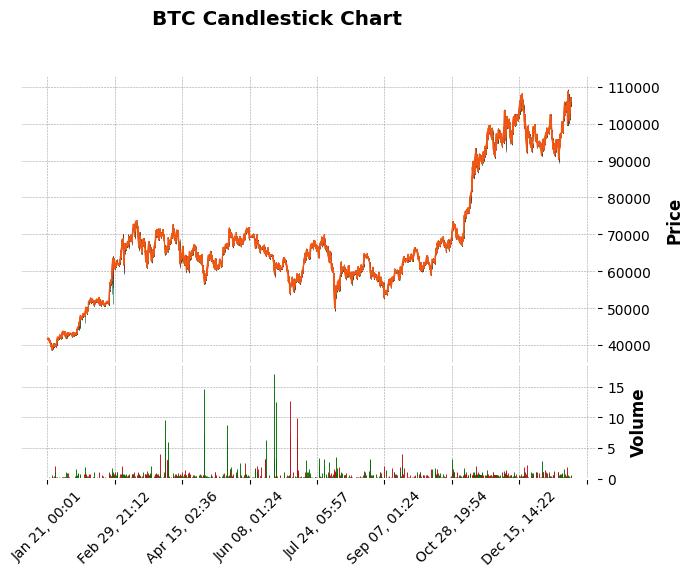

In [226]:
#GLOBAL VARIABLES -> function dependencies
data_minute = get_data(start = datetime(2024, 1, 21), end = datetime(2025, 1, 22))
data = {}
data_filled = {}
timestamps = {}

In [227]:
data["minute"] = data_minute
timestamps["minute"] = list(data_minute.index)

In [230]:
data["4h"], timestamps["4h"] = resample(data_minute, '4H')
data["10m"], timestamps["10m"] = resample(data_minute, '10Min')
data["30m"], timestamps["30m"] = resample(data_minute, '30Min')

for time in ["10m", "30m"]:
    data_filled[time] = fractal_fill(data[time])

100%|██████████| 17611/17611 [00:39<00:00, 447.87it/s]


In [232]:
data_filled["10m"]["signal"] = None
i = 0
for _, row in tqdm(data_filled["10m"].iterrows(), total = len(data_filled["10m"])):
    time = data_filled["10m"].index[i]
    if data_filled["10m"].loc[time, "fractal_type"] is not None: #bullish or bearish
        index, closest = find_closest(time, timestamps["30m"])
        if data_filled["10m"].loc[time, "fractal_type"] == "bearish":
            if index > 2:
                if tendency(index, "bearish", "30m"):
                    data_filled["10m"].loc[time, "signal"] = "bearish"
        else:
            if index > 2:
                if tendency(index, "bullish", "30m"):
                    data_filled["10m"].loc[time, "signal"] = "bullish"
    i += 1
# data_filled["10m"][data_filled["10m"]["signal"] == "bearish"]

100%|██████████| 52707/52707 [00:11<00:00, 4725.21it/s]


In [ ]:
plot_interactive_strategy(data_filled["10m"], signal_column="signal", filename = "unfiltered.html")

Interactive graph saved as unfiltered.html


# Filter out signals

In [233]:
def lambda2(time, signal, use = "1h"):
    global data, timestamps
    if use not in data.keys():
        data[use], timestamps[use] = resample(data["minute"], sample = use)
    index, closest = find_closest(time, timestamps[use])
    def lambda1(index, signal = "bearish", use = '1h'):
        global data, timestamps

        if use in data.keys():
            d = data[use]
            t = timestamps[use]
        else:
            data[use], timestamps[use] = resample(data["minute"])

        if index < 4:
            return False
        try:
            first = t[index - 4]
            second = t[index - 3]
            third = t[index - 2]
            fourth = t[index - 1]

            if signal == "bearish":
                if ((d.loc[first, "high"] < d.loc[second, "high"]) and (d.loc[second, "high"] < d.loc[third, "high"]) and (d.loc[third, "high"] > d.loc[fourth, "high"])):
                    return True
                # if ((d.loc[second, "high"] < d.loc[third, "high"]) and (d.loc[third, "high"] < d.loc[fourth, "high"])):
                #     return True
                
            if signal == "bullish":
                if ((d.loc[first, "low"] > d.loc[second, "low"]) and (d.loc[second, "low"] > d.loc[third, "low"]) and (d.loc[third, "low"] < d.loc[fourth, "low"])):
                    return True
                # if ((d.loc[second, "high"] > d.loc[third, "high"]) and (d.loc[third, "high"] > d.loc[fourth, "high"])):
                #     return True
        except:
            return False
        return False
    return lambda1(index, signal, use)

In [234]:
tqdm.pandas()
data_filled["10m"]["filtered"] = False
for i, row in tqdm(data_filled["10m"].iterrows(), total = len(data_filled)):
    data_filled["10m"].at[i, "filtered"] = lambda2(i, row["signal"], use = "4h")

52707it [00:08, 6225.38it/s]         


In [142]:
data_filled["10m"]["refined_signal"] = None
data_filled["10m"]["refined_signal"] = np.where(data_filled["10m"]["filtered"] == True, data_filled["10m"]["signal"], None)
plot_interactive_strategy(data_filled["10m"], signal_column = "refined_signal", filename = "check1.html")

Interactive graph saved as check1.html


In [235]:
data_filled["10m"]["refined_signal"] = None
data_filled["10m"]["refined_signal"] = np.where(data_filled["10m"]["filtered"] == True, data_filled["10m"]["signal"], None)
plot_interactive_strategy(data_filled["10m"], signal_column = "refined_signal", filename = "check2.html")

Interactive graph saved as check2.html


In [236]:
plot_interactive_strategy(data_filled["10m"], signal_column = "signal", filename = "unfiltered.html")

Interactive graph saved as unfiltered.html


# Strategy 1
Sell after 4hr

In [243]:
ACCOUNT = 0
HOLDING = 0
STOCKS = 0
sell_after = "4h"
signal = "signal"
pnl = []
if sell_after not in data.keys():
    data[sell_after], timestamps[sell_after] = resample(data["minute"], sample = sell_after)
for i, row in tqdm(data_filled["10m"].iterrows(), total = len(data_filled["10m"])):
    idx, closest = find_closest(i, timestamps[sell_after])
    if idx < len(timestamps[sell_after]):
        if row[signal] == "bearish":
            if STOCKS > 0:
                ACCOUNT -= (data[sell_after].at[data[sell_after].index[idx], "open"] - row["close"])
        elif row[signal] == "bullish":
            ACCOUNT += (data[sell_after].at[data[sell_after].index[idx], "open"] - row["close"])
        pnl.append(ACCOUNT)
print(ACCOUNT, HOLDING)

100%|██████████| 52707/52707 [00:05<00:00, 9760.84it/s] 

33909.88523695736 0


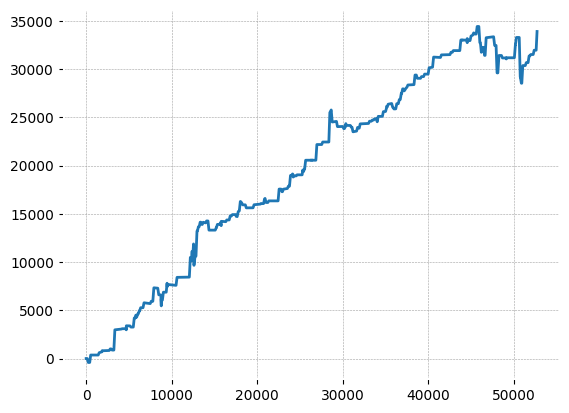

In [244]:
plt.plot(pnl)

In [183]:
print(HOLDING)

0


In [251]:
ACCOUNT = 0
HOLDING = 0
STOCKS = 0
sell_after = "4h"
signal = "signal"
pnl = []
if sell_after not in data.keys():
    data[sell_after], timestamps[sell_after] = resample(data["minute"], sample = sell_after)
for i, row in tqdm(data_filled["10m"].iterrows(), total = len(data_filled["10m"])):
    idx, closest = find_closest(i, timestamps[sell_after])
    if idx < len(timestamps[sell_after]):
        if row[signal] == "bearish":
            if STOCKS > 0:
                ACCOUNT += (row["close"]) * STOCKS
                STOCKS = 0
            else:
                STOCKS -= 1
                ACCOUNT += (row["close"])
        elif row[signal] == "bullish":
            if STOCKS < 0:
                ACCOUNT -= (row["close"]) * STOCKS
                STOCKS = 0
            else:
                STOCKS += 1
                ACCOUNT -= (row["close"])
        pnl.append(ACCOUNT)
print(ACCOUNT)

100%|██████████| 52707/52707 [00:05<00:00, 10224.66it/s]

22256996.785470683


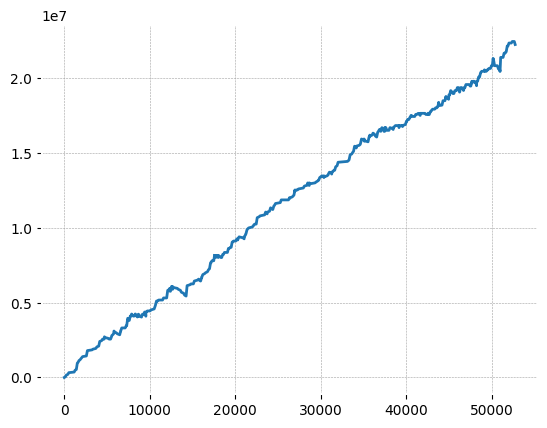

In [252]:
plt.plot(pnl)